In [8]:
from IPython.display import Image, display, HTML

CSS = """
.output {
    align-items: center;
}

.text_cell_render { /* Customize text cells */
line-height:2.5em;
}
"""

HTML('<style>{}</style>'.format(CSS))

## Stanford Databases Mini-Course DB5:
# SQL
### Notes by Leo Robinovitch
***

### Introduction:
* Pronounced "Sequel" :-)

* Declarative, high-level language whose foundations are based in relational algebra

* Standard supported by all major database systems
  * This course uses SQL2 or SQL92 standard as well as some constructs from SQL3 standard
  <br><br>

* Data Definition Language (DDL): includes commands to create a table, drop a table, and create/drop other database aspects (e.g. indexes and views)

* Data Manipulation Language (DML): language used to query and modify the database
  * Query database in SQL: Select Statement
  * Modify database in SQL: Insert, Delete, and Update Statements
<br><br>

* Recall from Relational Algebra notes, 3 relations that we work with as examples in this course:

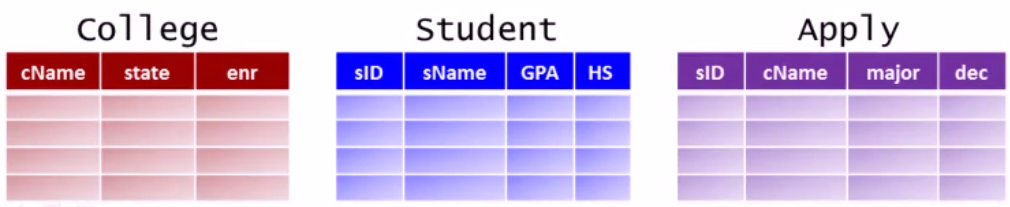

In [9]:
display(Image(filename='initialrelations.png', embed=True, width=800))

### Select Statement - Query a Database in SQL:
* Consists of three basic clauses:
  * Select $A_1, A_2,...,A_n \to$ specify what to return
  * From $R_1, R_2,...,R_m \to$ specify relations to query over
  * Where $condition \to$ combine and filter relations
  <br><br>
  
* In relational algebra, Select is equivalent to
$$\Pi_{A_1,A_2,...,A_n}(\sigma_{condition}(R_1\ X\ R_2\ X\ ...\ X\ R_m))$$
<br>

* Examples: 

```sql
select sID, sName
from Student
where GPA > 3.6;

select distinct sName, major    -- distinct keyword ensures no duplicates
from Student, Apply
where Student.sId = Apply.sID;

select sName, GPA, dec
from Student, Apply
where Student.sID = Apply.sID and sizeHS < 1000 and major = 'CS' and cName = 'Stanford';

select Student.sID, sName, GPA, Apply.cName, enrollment    -- specific relations avoid ambiguity (sID, cName)
from Student, College, Apply
where Apply.sID = Student.sID and Apply.cName = College.cName
order by GPA desc, enrollment;    -- sort results first by descending GPA & within same GPA, by ascending enrollment

select sID, major
from Apply
where major like '%bio%';    -- match any major where there's some set of chars, then 'bio', then some set of chars

-- Cross product of Student and College with no filtering:
select *
from Student, College;

select sID, sName, GPA, sizeHS, GPA * (sizeHS / 1000.0) as scaledGPA    -- rename last attribute with 'as'
from Student;
```

* Note that SQL is based in multisets and returns duplicates by default

* By default, SQL sorts in ascending order ('asc' keyword default in *sort by*)

* To get all attributes: select *

* Can use algebra in select statements

* Easy to rename attributes with *as* statement within select
<br><br>

### Table Variables (in From clause):
* Usefullness:
  1. Improve readability
  2. Rename relations used in From clause (particularly with two instances of same relation)
  <br><br>

```sql
-- Rename relations in From clause using second variable before comma:
select S.ID, sName, GPA, A.cName, enrollment
from Student S, College C, Apply A
where A.sID = S.sID and A.cName = C.cName;

-- All pairs of students that have the same GPA:
select S1.sID, S1.sName, S1.GPA, S2.sID, S2.sName, S2.GPA
from Student S1, Student S2    -- Repeated relation here -> does cross product here (all possible pairs)
where S1.GPA = S2.GPA and S1.sID < S1.sID;    -- Note that "!=" is "<>" in SQL -> using less-than to avoid doubles
```

### Set Operators: Union, Intersect and Except:
**Union: generate "stacking" of multiple relations**

* Example:

```sql
select cName as name from College    -- "as" statement specifies new attribute name
union all    -- remove "all" statement to remove duplicates (in SQL, removing duplicates sorts entries)
select sName as name from Student    -- "as" statement specifies new attribute name
order by name;    -- ensures sorted order
```

**Intersect: generate overlapping subset of multiple relations**

* Example:

```sql
select sID from Apply where major = 'CS'
intersect
select sID from Apply where major = 'EE';
 
-- Some database systems don't support intersect operator: 
select distinct A1.sID    -- note the distinct here to remove duplicates
from Apply A1, Apply A2     -- every pair of Apply tuples
where A1.sID = A2.sID and A1.major = 'CS' and A2.major = 'EE'; 
```

**Except (or Minus, Difference): generate conditional subset of multiple relations**
  
* Example:

```sql
select sId from Apply where major = 'CS'
except
select sID from Apply where major = 'EE'

-- Some database systems don't support except operator:
select distinct A1.sID
from Apply A1, Apply A2
where A1.sID = A2.sID and A1.major = 'CS' and A2.major <> 'EE';
-- THIS DOES NOT RETURN THE SAME AS ABOVE! RETRUNS sIDs BASED ON ALL MAJOR PAIRS, SO PASSES MORE PEOPLE THAN IT SHOULD. NOT ACTUALLY POSSIBLE TO WRITE DIFFERENCE WITHOUT EXCEPT OPERATOR WITH TOOLS SO FAR! SEE '@@' BELOW!
```

### Subqueries in Where Clause:
* Nested select statements within where clause

```sql
-- Previous way to do it:
select distinct Student.sID, sName    -- note the disambiguation here (both relations have sID attributes) 
from Student, Apply
where Student.sID = Apply.sID and Apply.major = 'CS';

-- New way to do it with subqueries in where clause (note this does not require the "distinct" like above)
select sID, sName
from Student
where sID in (select sID from Apply where major = 'CS');
```

* Note that the "distinct" keyword filters on the final resulting relation. 
  * E.g. If you're just pulling names of students with certain conditions and there are 2 Craigs that fit the condition, "distinct" will filter out one of the Craigs because it is just looking at a column of names! This is undesirable.
<br><br>

* This becomes super important when it comes to counting and eliminating duplicates
  * Sometimes subqueries in Where clause is the ONLY way to get what you want accurately:

```sql
-- This returns the 5 GPAS from 5 students who applied to CS at any school:
select GPA
from Student
where sID in (select sID from Apply where major = 'CS');

-- This returns duplicates (without "distinct"), but putting "distinct" eliminates equal GPAs! Neither good!
select GPA
from Student, Apply
where Student.sID = Apply.sID and major = 'CS';

-- Can now write previous query properly for database systems that don't accept "Except"! @@
select sID, sName
from Student
where sID in (select sID from Apply where major = 'CS') 
    and sID not in (select sID from Apply where major = 'EE'); -- could also write "and not sID in select.."
```

* The **exists** operator: returns where something exists or does not exist (masking)

```sql
-- All colleges such that some other college is in the same state:
select cName, state
from College C1
where exists (select * from College C2
              where C2.state = C1.state and C1.cName <> C2.cName);
              
-- College with largest enrollment -> all colleges where there doesn't exist other college with > enrollment
select cName
from College C1
where not exists (select * from College C2
                  where C2.enrollment > C1.enrollment);
                  
-- Note that this cannot be done with joins - below finds all students s.t. some other student has lower GPA
select distinct S1.sName, S1.GPA
from Student S1, Student S2
where S1.GPA > S2.GPA;
    -- again, this is WRONG
```

* The **all** operator: does a value have a relationship with ALL the results of a subquery?

```sql
-- Another correct way of finding a max using subqueries and the "all" keyword:
select sName, GPA
from Student
where GPA >= all (select GPA from Student);

-- Replace >= with > (just another valid way of doing maximums):
select cName, GPA
from College C1
where enrollment > all (select College from College C2
                        where C2.enrollment <> C2.enrollment);
    -- NOTE: THIS WOULD NOT WORK IF THERE WERE MULTIPLE COLLEGES WITH EQUAL MAXIMUM ENROLLMENT VALUES
```

* The **any** operator: does a value satisfy a condition with at least one of the results of a subquery?

```sql
-- Return all colleges where it's not the case that the enrollment is <= to any other college:
select cName, GPA
from College C1
where not enrollment <= any (select College from College C2
                             where C2.enrollment <> C2.enrollment);
    -- NOTE: THIS WOULD NOT WORK IF THERE WERE MULTIPLE COLLEGES WITH EQUAL MAXIMUM ENROLLMENT VALUES

-- Find all students not from the smallest highschool:
select sID, sName, sizeHS
from Student
where sizeHS > any (select sizeHS from Student);

-- SQLite and other database systems do not support "any" and "all" operators:
select sID, sName, sizeHS
from Student S1
where exists (select * from Student S2 where S2.sizeHS < S1.sizeHS);

-- Students who applied to CS but not to EE using "any":
select sID, sName
from Student
where sID = any (select sID from Apply where major = 'CS')
            and not sID = any (select sID from Apply where major = 'EE');
```

### Subqueries in From and Select Clauses:
* Example of nested subqueries in From clause:

```sql
-- Students whose scaled GPA changes GPA by more than 1:
select sID, sName, GPA, GPA*(sizeHS / 1000.0) as scaledGPA
from Student
where GPA*(sizeHS/1000.0) - GPA > 1.0 or GPA - GPA*(sizeHS/1000.0) > 1.0;

-- Interesting, equivalent statement:
select * 
from (select sID, sName, GPA, GPA*(sizeHS / 1000.0) as scaledGPA) G    -- name subquery G
where abs(G.scaledGPA - GPA) > 1.0;    -- abs is built in to SQL
```

* Example of nested subqueries in Select clause:

```sql
-- Pair colleges with highest GPA among applicants:
select distinct College.cName, state, GPA
from College, Apply, Student    -- join all relations
where College.cName = Apply.cName
  and Apply.sID = Student.sID
  and GPA >= all (select GPA from Student, Apply where Student.sID = Apply.sID and Apply.cName = College.cName);

-- Using subquery in Select clause:
select cName, state, 
(select distinct GPA
from Apply, Student
where College.cName = Apply.cName
  and Apply.sID = Student.sID
  and GPA >= all (select GPA from Student, Apply 
  where Student.sID = Apply.sID and Apply.cName = College.cName)) as GPA
from College;

-- NOTE: Subquery in Select statement must return exactly one row - below does not work:
select cName, state, 
(select distinct sName
from Apply, Student
where College.cName = Apply.cName
  and Apply.sID = Student.sID) as sName
from College;
```

### Aggregation:
*

In [11]:
!jupyter nbconvert DB5_SQL_Notes.ipynb --to html --TemplateExporter.exclude_input=True

[NbConvertApp] Converting notebook DB5_SQL_Notes.ipynb to html
[NbConvertApp] Writing 471137 bytes to DB5_SQL_Notes.html
